# Distance and Approximations

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.datasets import load_gunpoint

## A simple ML classifier

In [4]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [5]:
X_train, y_train = load_gunpoint(split="TRAIN", return_X_y=True, return_type="numpy3D")
X_test, y_test = load_gunpoint(split="TEST", return_X_y=True, return_type="numpy3D")
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50, 1, 150), (50,), (150, 1, 150), (150,))

In [6]:
classifier = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="euclidean")

In [7]:
classifier.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier(distance='euclidean')

In [8]:
# accuracy
classifier.score(X_test, y_test)

0.9133333333333333

## Load the data

In [9]:
X, classes = load_gunpoint(return_type="numpy3D")
X.shape

(200, 1, 150)

In [10]:
ts1 = X[0, 0, :]
ts2 = X[10, 0, :]
ts1.shape, ts2.shape

((150,), (150,))

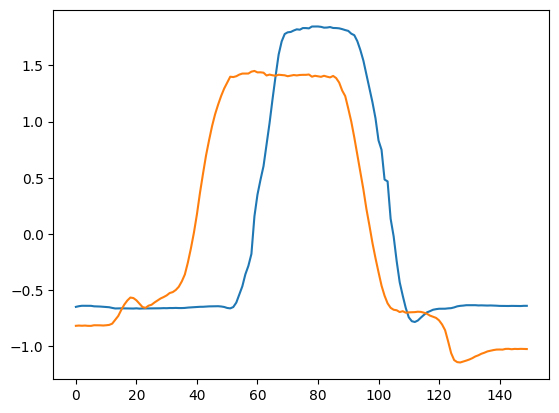

In [11]:
plt.plot(ts1)
plt.plot(ts2)
plt.show()

## Distances

In [12]:
from sktime.distances import distance

In [13]:
distance(ts1, ts2, metric="euclidean")

np.float64(9.448621148484975)

In [14]:
distance(ts1, ts2, metric="dtw")

np.float64(8.899233341263871)

In [15]:
distance(ts1, ts2, metric="dtw", window=0.1)

np.float64(14.451891982183026)

In [16]:
distance(ts1, ts2, metric="dtw", itakura_max_slope=0.2)

np.float64(8.899233341263871)

### Visualize alignments
You will probably never use this, but it is good to know that you can visualize the alignments.

In [17]:
from sktime.alignment.dtw_numba import AlignerDtwNumba
from sktime.alignment.naive import AlignerNaive

#### Euclidean

In [18]:
aligner = AlignerNaive()
aligner.fit([pd.DataFrame(ts1), pd.DataFrame(ts2)])
alignments = aligner.get_alignment()
aligned_1, aligned_2 = aligner.get_aligned()

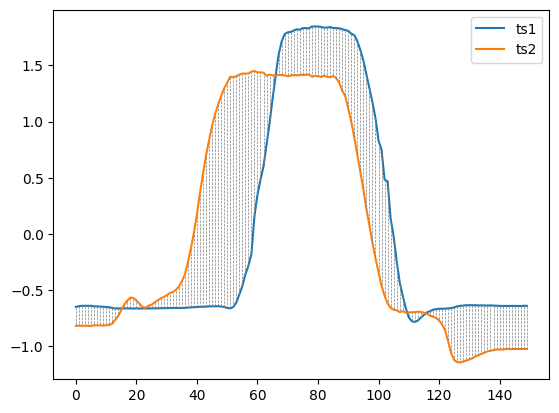

In [19]:
plt.plot(ts1, c="C0", label="ts1")
plt.plot(ts2, c="C1", label="ts2")
for index, row in alignments.iterrows():
    ind0 = row['ind0']
    ind1 = row['ind1']
    plt.plot([ind0, ind1], [ts1[ind0], ts2[ind1]], color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

#### DTW

In [20]:
aligner = AlignerDtwNumba()
aligner.fit([pd.DataFrame(ts1), pd.DataFrame(ts2)])
alignments = aligner.get_alignment()
aligned_1, aligned_2 = aligner.get_aligned()

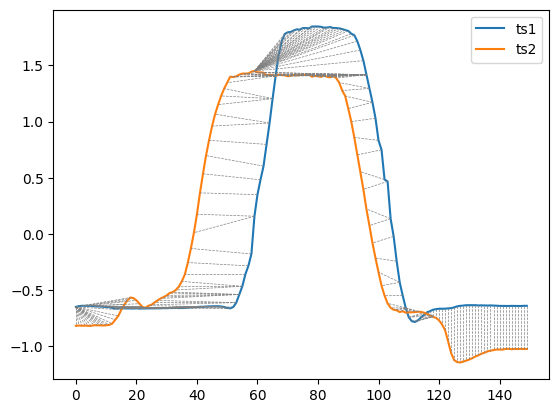

In [21]:
plt.plot(ts1, c="C0", label="ts1")
plt.plot(ts2, c="C1", label="ts2")
for index, row in alignments.iterrows():
    ind0 = row['ind0']
    ind1 = row['ind1']
    plt.plot([ind0, ind1], [ts1[ind0], ts2[ind1]], color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

##### Two ways of looking at the same thing

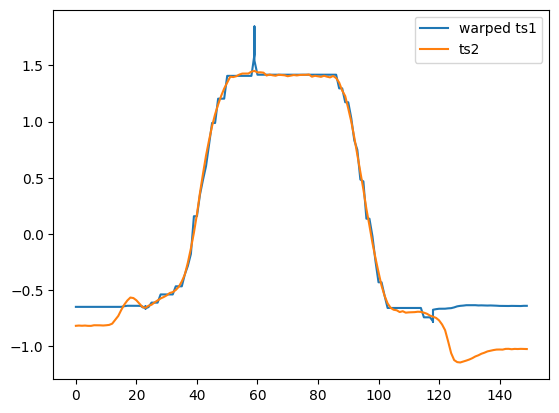

In [22]:
# warping ts1 to "fit" ts2
plt.plot(alignments["ind1"], aligned_1, label="warped ts1")
plt.plot(alignments["ind1"], aligned_2, label="ts2")
plt.legend()
plt.show()

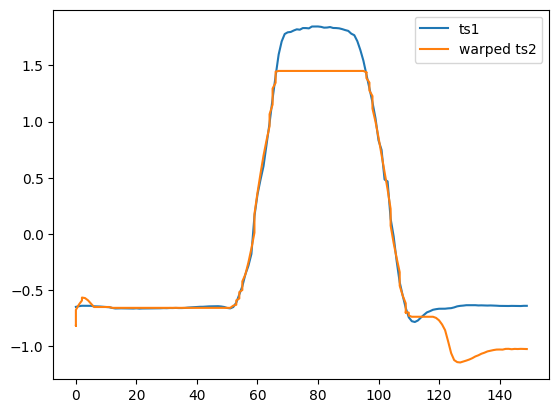

In [23]:
# warping ts2 to "fit" ts1
plt.plot(alignments["ind0"], aligned_1, label="ts1")
plt.plot(alignments["ind0"], aligned_2, label="warped ts2")
plt.legend()
plt.show()

#### DTW with sakoe-chiba window

In [24]:
aligner = AlignerDtwNumba(window=0.1)
aligner.fit([pd.DataFrame(ts1), pd.DataFrame(ts2)])
alignments = aligner.get_alignment()
aligned_1, aligned_2 = aligner.get_aligned()

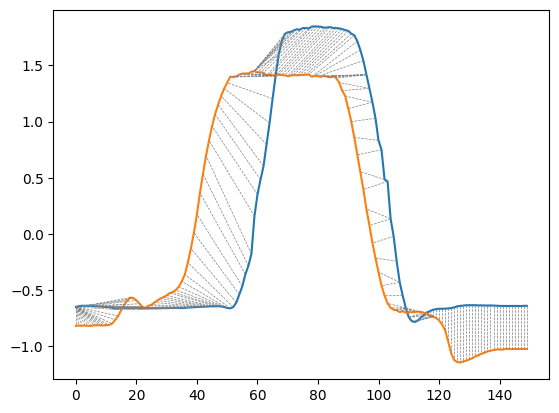

In [25]:
plt.plot(ts1, c="C0", label="ts1")
plt.plot(ts2, c="C1", label="ts2")
for index, row in alignments.iterrows():
    ind0 = row['ind0']
    ind1 = row['ind1']
    plt.plot([ind0, ind1], [ts1[ind0], ts2[ind1]], color='gray', linestyle='--', linewidth=0.5)

#### DTW with itakura max slope

In [26]:
aligner = AlignerDtwNumba(itakura_max_slope=0.1)
aligner.fit([pd.DataFrame(ts1), pd.DataFrame(ts2)])
alignments = aligner.get_alignment()
aligned_1, aligned_2 = aligner.get_aligned()

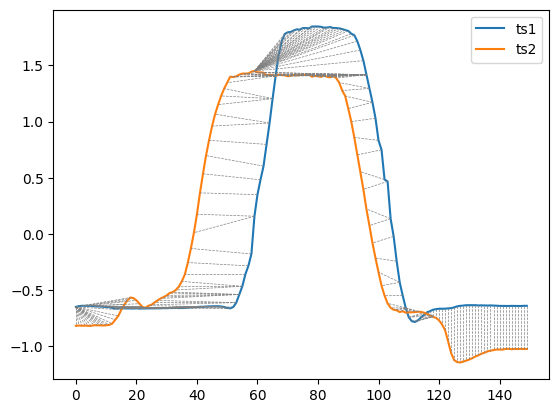

In [27]:
plt.plot(ts1, c="C0", label="ts1")
plt.plot(ts2, c="C1", label="ts2")
for index, row in alignments.iterrows():
    ind0 = row['ind0']
    ind1 = row['ind1']
    plt.plot([ind0, ind1], [ts1[ind0], ts2[ind1]], color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Approximation

### PAA

In [28]:
from sktime.transformations.series.paa import PAA

In [29]:
paa = PAA(frame_size=16) # frame_size (n points in each segment), frames (number of segments)

In [30]:
ts_paa = paa.fit_transform(ts1)
ts_paa.shape

(10,)

#### Visualize the PAA approximation

/tmp/ipykernel_8867/1813517195.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(ts_paa, "r-", label="PAA", linestyle='--')


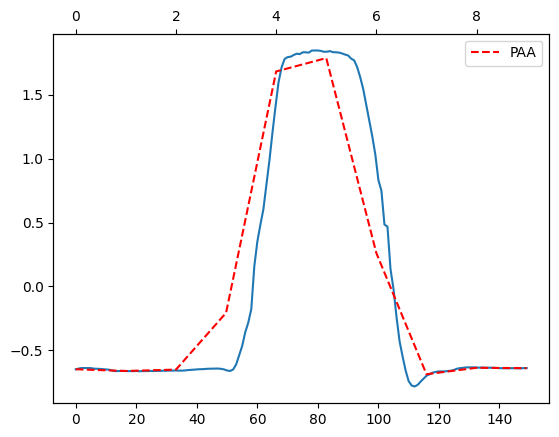

In [31]:
fig, ax1 = plt.subplots()
plt.grid(False)
ax1.plot(ts1)
ax2 = ax1.twiny()
ax2.plot(ts_paa, "r-", label="PAA", linestyle='--')
plt.grid(False)
plt.legend()
plt.show()

#### Visualize the PAA approximation, interpolated

In [32]:
from sktime.transformations.panel.interpolate import TSInterpolator

In [33]:
ts_paa_interpolated = TSInterpolator(len(ts1)).fit_transform(ts_paa)
ts_paa_interpolated.shape

(150, 1)

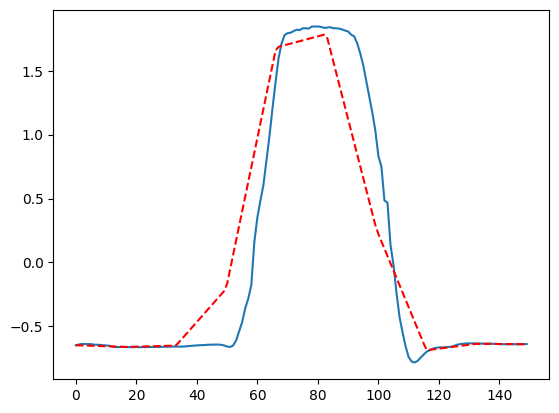

In [34]:
plt.plot(ts1)
plt.plot(ts_paa_interpolated, c="r", linestyle='--')
plt.show()

### SAX

In [35]:
from sktime.transformations.series.sax import SAX
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

In [36]:
sax = SAX(word_size=20, alphabet_size=5)

In [37]:
ts_sax = sax.fit_transform(ts1)

/tmp/ipykernel_8867/2256990845.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(scaler.fit_transform(ts_sax.reshape(-1, 1)), "r-", label="SAX", linestyle='--')


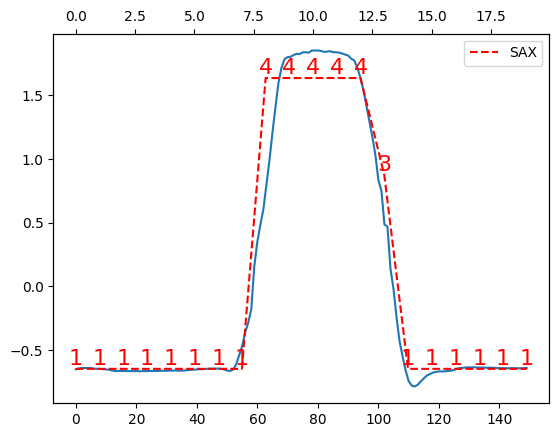

In [38]:
fig, ax1 = plt.subplots()
scaler = TabularToSeriesAdaptor(StandardScaler(), fit_in_transform=True)
ts_scaled = scaler.fit_transform(ts1.reshape(-1, 1))
ts_sax_scaled = scaler.fit_transform(ts_sax.reshape(-1, 1))
plt.grid(False)
ax1.plot(ts_scaled)

ax2 = ax1.twiny()
ax2.plot(scaler.fit_transform(ts_sax.reshape(-1, 1)), "r-", label="SAX", linestyle='--')
for i in range(len(ts_sax)):
    ax2.text(i, ts_sax_scaled[i], ts_sax[i], fontsize=16, color='r', horizontalalignment='center', verticalalignment='bottom')
plt.grid(False)
plt.legend()
plt.show()

### Discrete Fourier Transform

In [39]:
from pyts.approximation import DiscreteFourierTransform
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # https://pyts.readthedocs.io/en/latest/auto_examples/approximation/plot_dft.html
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

ModuleNotFoundError: No module named 'pyts'

In [ ]:
n_coefs = 10
dft = DiscreteFourierTransform(n_coefs=n_coefs)

In [ ]:
coefs = dft.fit_transform(ts1.reshape(1, -1))

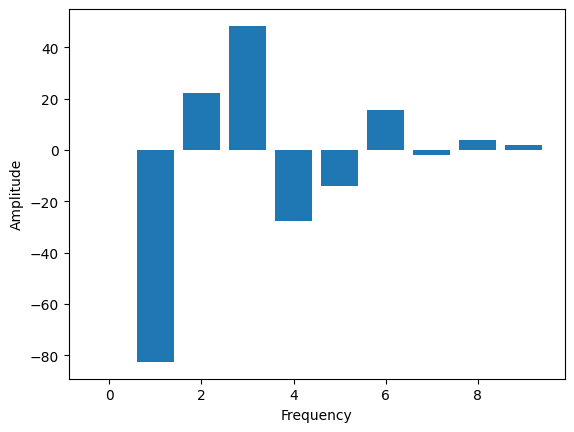

In [ ]:
plt.bar(np.arange(len(coefs.ravel())), coefs.ravel())
plt.ylabel("Amplitude")
plt.xlabel("Frequency")
plt.show()

In [ ]:
ts_dtf_approx = dft_inverse_trasform(coefs, n_coefs, len(ts1))

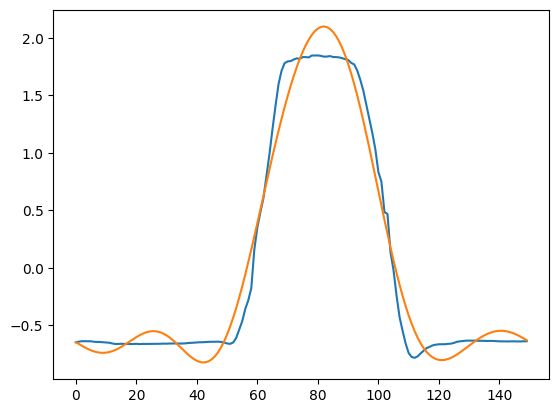

In [ ]:
plt.plot(ts1)
plt.plot(ts_dtf_approx.ravel())

### SFA

In [ ]:
from pyts.approximation.sfa import SymbolicFourierApproximation
from sktime.transformations.panel.dictionary_based import SFA

In [ ]:
sfa = SFA(word_length=10, alphabet_size=5, window_size=len(ts1), save_words=True)

In [ ]:
ts_sfa = sfa.fit_transform(ts1.reshape(1, 1, -1))
ts_sfa = sfa.word_list(word=list(ts_sfa[0][0].keys())[0])

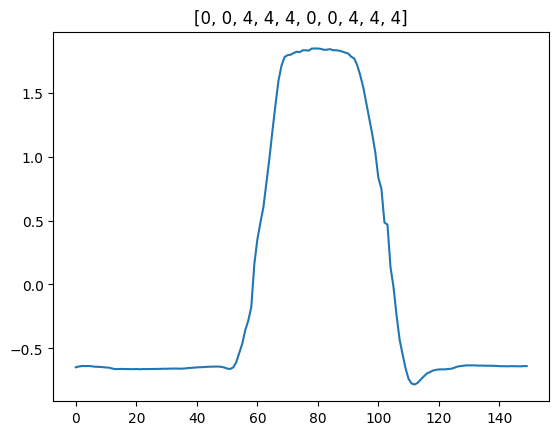

In [ ]:
plt.plot(ts1)
plt.title(str(ts_sfa))
plt.show()

### PCA

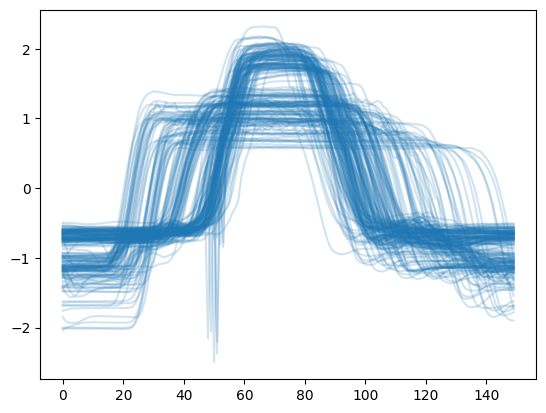

In [ ]:
plt.plot(X[:, 0, :].T, color="C0", alpha=0.2) 
plt.show()

#### PCA as an approximator

In [ ]:
from sktime.transformations.panel.pca import PCATransformer
from sklearn.preprocessing import StandardScaler

In [ ]:
X_scaled = TabularToSeriesAdaptor(StandardScaler(), fit_in_transform=True).fit_transform(X)
pca = PCATransformer(20, random_state=0)
X_pca = pca.fit_transform(X_scaled)

Text(0, 0.5, 'cumulative explained variance')

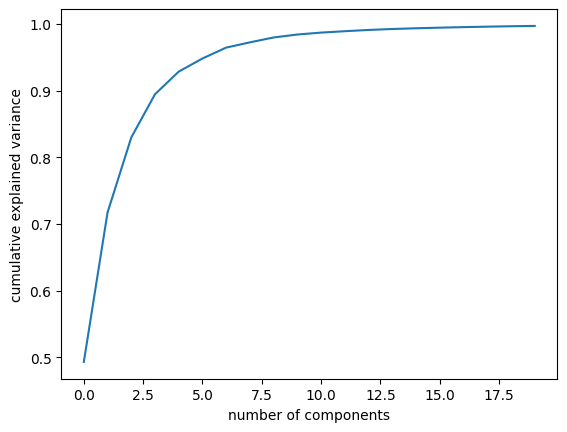

In [ ]:
plt.plot(np.cumsum(pca.pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
pca = PCATransformer(3, random_state=0)
X_pca = pca.fit_transform(X_scaled)

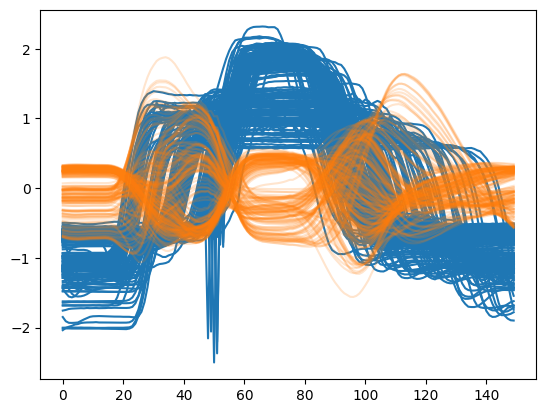

In [ ]:
plt.plot(X[:,0,:].T, color="C0")
plt.plot(X_pca[:, 0, :].T, color="C1", alpha=0.2) 
plt.show()

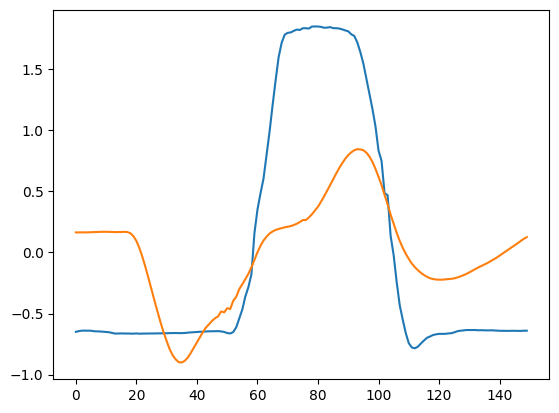

In [ ]:
plt.plot(X_scaled[0, 0])
plt.plot(X_pca[0, 0])
plt.show()

#### PCA as a compressor

In [ ]:
from sktime.transformations.panel.reduce import Tabularizer
from sklearn.decomposition import PCA

In [ ]:
pca_compressor = Tabularizer() * PCA(2, random_state=0)
pca_compressor

TransformerPipeline(steps=[Tabularizer(),
                           TabularToSeriesAdaptor(transformer=PCA(n_components=2, random_state=0))])

In [ ]:
X_compressed = pca_compressor.fit_transform(X_scaled).to_numpy()
X_compressed.shape

(200, 2)

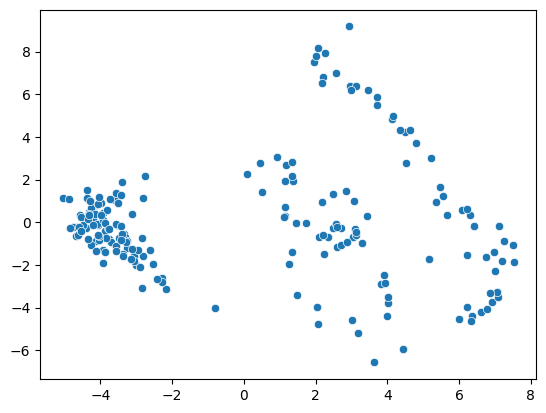

In [ ]:
sns.scatterplot(x=X_compressed[:, 0], y=X_compressed[:, 1])
plt.show()

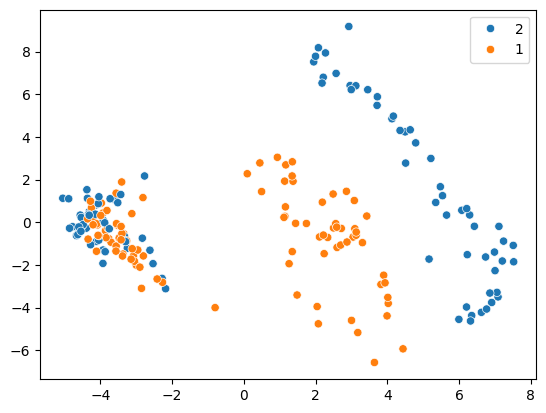

In [ ]:
sns.scatterplot(x=X_compressed[:, 0], y=X_compressed[:, 1], hue=classes)
plt.show()

### Trucated SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sktime.transformations.panel.compose import ColumnConcatenator

In [ ]:
svd = TruncatedSVD(2, random_state=0)

In [ ]:
X_compressed = svd.fit_transform(X_scaled[:, 0, :])

<Axes: >

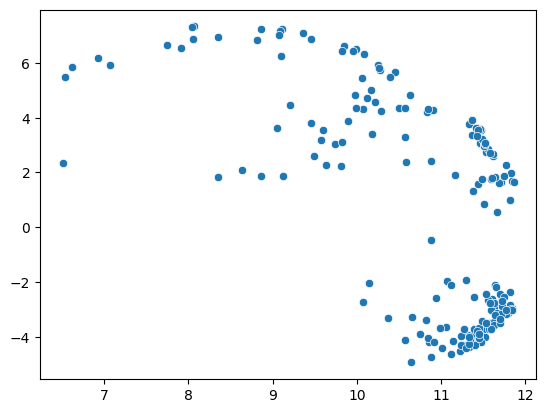

In [ ]:
sns.scatterplot(x=X_compressed[:, 0], y=X_compressed[:, 1])

<Axes: >

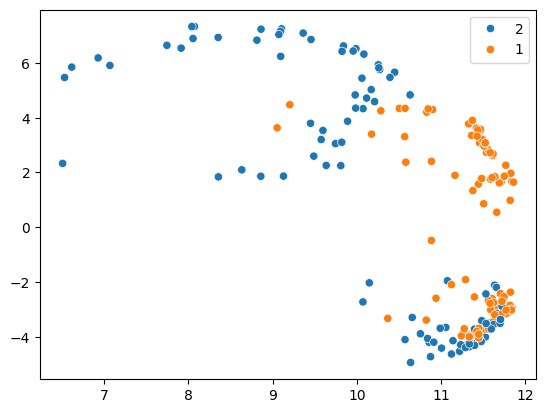

In [ ]:
sns.scatterplot(x=X_compressed[:, 0], y=X_compressed[:, 1], hue=classes)

In [ ]:
X_svd = svd.inverse_transform(X_compressed)

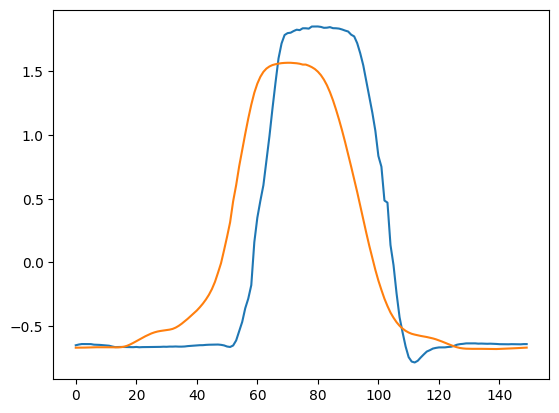

In [ ]:
plt.plot(X_scaled[0, 0])
plt.plot(X_svd[0])
plt.show()

## Feature extraction

### Structure-based similarity

#### Basic Features

##### Global Features

In [ ]:
from sktime.transformations.series.summarize import SummaryTransformer

In [ ]:
summary = SummaryTransformer(summary_function= ("mean", "min", "max", "median", "sum", "skew", "kurt", "var", "std", "mad", "sem", "nunique", "count"))

In [ ]:
X_features = summary.fit_transform(X)
X_features.head()

,mean,min,max,median,sum,skew,kurt,var,std,mad,sem,nunique,count,0.1,0.25,0.5,0.75,0.9
instances,,,,,,,,,,,,,,,,,,
0,-4.000000e-10,-0.782461,1.845811,-0.639052,-6.000000e-08,1.051883,-0.707909,1.0,1.0,0.872841,0.08165,149.0,150.0,-0.662376,-0.658058,-0.639052,0.785012,1.817564
1,-7.400000e-10,-0.814203,1.925177,-0.609387,-1.110000e-07,1.102117,-0.550013,1.0,1.0,0.862997,0.08165,149.0,150.0,-0.686238,-0.643350,-0.609387,0.719290,1.888367
2,-1.893333e-09,-0.782672,1.703739,-0.598165,-2.840000e-07,0.894229,-1.031952,1.0,1.0,0.889577,0.08165,149.0,150.0,-0.774612,-0.739111,-0.598165,1.096573,1.679056
3,1.586667e-09,-0.792305,1.783278,-0.559942,2.380000e-07,0.978800,-0.830263,1.0,1.0,0.873468,0.08165,149.0,150.0,-0.745996,-0.741088,-0.559942,0.850966,1.766673
4,2.400000e-09,-0.733465,2.053367,-0.573590,3.600000e-07,1.274075,-0.130244,1.0,1.0,0.839327,0.08165,149.0,150.0,-0.643583,-0.599016,-0.573590,0.471034,2.024544


In [ ]:
ts1_features = X_features.iloc[0].to_numpy()
ts2_features = X_features.iloc[10].to_numpy()

In [ ]:
distance(ts1_features, ts2_features, metric="euclidean")

1.393586209172773

#### TSFresh

In [ ]:
# !pip install tsfresh

In [ ]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [ ]:
tsfresh = TSFreshFeatureExtractor()

In [ ]:
%%time
X_tsfresh = tsfresh.fit_transform(X)
X_tsfresh.head()

Feature Extraction:   0%|                                 | 0/200 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extr

Feature Extraction:   4%|█                        | 8/200 [00:00<00:02, 75.56it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to have a index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'>. Results will not be calculated
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to have a index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'>. Results will not be calculated
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to have a index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'>. Results will not be calculated
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to have a index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'>. Results will not be calculated
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to have a index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'>. Results will not be calculated
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to have a index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'>. Results will not be calculated
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to have a index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'>. Results will not be calculated
  warnings.warn(
Feature Extraction:  82%|██████████████████▉    | 165/200 [00:02<00:00, 81.33it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/feature_calculators.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/feature_extraction/extraction.py:354: UserWarning: linear_trend_timewise requires the data to 

CPU times: user 2.51 s, sys: 72.9 ms, total: 2.58 s
Wall time: 2.59 s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['var_0__fft_coefficient__attr_"real"__coeff_76'
 'var_0__fft_coefficient__attr_"real"__coeff_77'
 'var_0__fft_coefficient__attr_"real"__coeff_78'
 'var_0__fft_coefficient__attr_"real"__coeff_79'
 'var_0__fft_coefficient__attr_"real"__coeff_80'
 'var_0__fft_coefficient__attr_"real"__coeff_81'
 'var_0__fft_coefficient__attr_"real"__coeff_82'
 'var_0__fft_coefficient__attr_"real"__coeff_83'
 'var_0__fft_coefficient__attr_"real"__coeff_84'
 'var_0__fft_coefficient__attr_"real"__coeff_85'
 'var_0__fft_coefficient__attr_"real"__coeff_86'
 'var_0__fft_coefficient__attr_"real"__coeff_87'
 'var_0__fft_coefficient__attr_"real"__coeff_88'
 'var_0__fft_coefficient__attr_"real"__coeff_89'
 'var_0__fft_coefficient__attr_"real"__coeff_90'
 'var_0__fft_coefficient__attr_"real"__coeff_91'
 'var_0__fft_coefficient__attr_"real"__coeff_92'
 'var_0__fft_

,var_0__variance_larger_than_standard_deviation,var_0__has_duplicate_max,var_0__has_duplicate_min,var_0__has_duplicate,var_0__sum_values,var_0__abs_energy,var_0__mean_abs_change,var_0__mean_change,var_0__mean_second_derivative_central,var_0__median,...,var_0__fourier_entropy__bins_5,var_0__fourier_entropy__bins_10,var_0__fourier_entropy__bins_100,var_0__permutation_entropy__dimension_3__tau_1,var_0__permutation_entropy__dimension_4__tau_1,var_0__permutation_entropy__dimension_5__tau_1,var_0__permutation_entropy__dimension_6__tau_1,var_0__permutation_entropy__dimension_7__tau_1,var_0__query_similarity_count__query_None__threshold_0.0,var_0__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,1.0,-6.000000e-08,149.000000,0.036303,0.000062,-0.000020,-0.639052,...,0.191393,0.260914,0.417646,1.451715,2.244152,2.811924,3.156746,3.385291,0.0,1.841624
1,0.0,0.0,0.0,1.0,-1.110000e-07,148.999999,0.037238,0.000086,0.000013,-0.609387,...,0.242673,0.242673,0.399405,1.248975,1.825556,2.310987,2.699411,3.003630,0.0,1.921007
2,0.0,0.0,0.0,1.0,-2.840000e-07,148.999999,0.035247,0.000478,0.000001,-0.598165,...,0.209634,0.209634,0.417646,1.277395,1.830055,2.369587,2.811302,3.203934,0.0,1.700243
3,0.0,0.0,0.0,1.0,2.380000e-07,149.000001,0.035324,0.000170,-0.000005,-0.559942,...,0.209634,0.279155,0.399405,1.320130,1.949767,2.477421,2.870676,3.107572,0.0,1.780402
4,0.0,0.0,0.0,1.0,3.600000e-07,149.000001,0.039413,-0.000216,0.000010,-0.573590,...,0.242673,0.260914,0.537144,1.498303,2.329707,3.003242,3.320888,3.523892,0.0,2.043366


In [ ]:
ts1_tsfresh = X_tsfresh.iloc[0].to_numpy()
ts2_tsfresh = X_tsfresh.iloc[10].to_numpy()

In [ ]:
distance(ts1_tsfresh, ts2_tsfresh, metric="euclidean")

3304148129.612794

#### Catch22

In [ ]:
from sktime.transformations.panel.catch22 import Catch22

In [ ]:
catch22 = Catch22()

In [ ]:
%%time
X_catch22 = catch22.fit_transform(X)
X_catch22.head()

CPU times: user 4.8 s, sys: 413 ms, total: 5.21 s
Wall time: 5.23 s


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.519634,-0.651047,47.0,0.100000,-0.326667,19.0,48.0,0.989975,0.049087,0.146810,...,26.0,0.221477,29.0,1.315707,0.642857,2.705024,0.850,0.150,0.0800,0.0
1,-0.540265,-0.677234,46.0,0.026667,-0.306667,19.0,50.0,0.990176,0.049087,0.142685,...,26.0,0.248322,26.0,1.296189,0.703704,3.736540,0.825,0.775,0.0400,0.0
2,-0.534031,-0.658351,50.0,0.026667,-0.360000,21.0,53.0,0.989140,0.049087,0.140314,...,28.0,0.221477,34.0,1.253208,1.033333,3.003425,0.850,0.775,0.0625,0.0
3,-0.534747,-0.663526,49.0,-0.020000,0.336667,21.0,53.0,0.989461,0.049087,0.134839,...,28.0,0.241611,33.0,1.296189,0.965517,3.920290,0.850,0.750,0.0400,0.0
4,-0.454781,-0.594123,43.0,-0.060000,0.300000,18.0,48.0,0.989789,0.049087,0.160698,...,24.0,0.214765,19.0,1.323159,0.576923,3.221290,0.850,0.200,0.0400,0.0


In [ ]:
ts1_catch22 = X_catch22.iloc[0,:-1].to_numpy()  # the last value is a NaN
ts2_catch22 = X_catch22.iloc[10,:-1].to_numpy()  # the last value is a NaN

In [ ]:
distance(ts1_catch22, ts2_catch22, metric="euclidean")

17.851150919055762